In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random
import copy
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

### 委员会
也就是我们常说的bagging方法，它的存在主要是为了降低模型方差。首先，我们选择一个(或多个)基础算法作为基学习器，为了让这些基学习器学习到不同的知识，我们用不同的采样方法采样出不同的训练集来训练多个基学习器模型。最终的模型预测输出为$ y = \frac{1}{M}\sum_{m=1}^Mf(x) $，单个学习器的方差，因为是从原始分布中采样，为$ E(loss^2(x)) $。而使用了集成后的方差应为$ \frac{1}{M}E(loss^2(x)) $。至于偏差，我们不认为bagging会改变基学习器的偏差，因为数据分布和学习器算法性能都没有得到提升。 
常用的bagging算法是随机森林。在实践中我们会看到，在使用高随机度决策树时形成委员会时，决策树的表现一般要好过单棵决策树很多，RF也是今天深度学习时代仍然排得上号的优秀数据挖掘算法。  
**如果你不熟悉决策树，可以参考附件的资料DT paper**

### 决策树的连续特征
纯离散特征的问题，用单棵决策树加一些技巧就可以很好处理。如果涉及连续型特征，单棵决策树很有可能产生偏激的划分方法，但是如果用多棵树组成森林，就能一定程度上避免这个弊端。  
连续特征的处理技巧在paper里介绍了，C4.5使用的朴素划分方法是遍历所有可能的划分点，选择最好的点进行二分。这个方法看起来跑得就很慢，每次这个操作时，首先我们要排序N大小的数据，然后扫描一遍计算信息增益，而且要对所有属性都做相同的事情。而且这个操作要执行树的深度那么多次。我们一般认为这个算法的复杂度达到O(nlogn x n x a x logn)，所以连续特征很多的时候尽量避免用C4.5，用神经网络说不定都能更快一点。  

### 实战
Sklearn的toy datasets都是连续特征为主，不是很适合训练决策树。我在Github上随便找了一个离散属性为主的数据集，名叫mushrooms。包括对应于姬松茸和Lepiota家族中23种蘑菇的假设样品的描述。 每个物种都被确定为绝对可食用，绝对有毒，或具有未知的可食性，不推荐使用。 后一类与有毒类相结合。属性都为离散属性，包括蘑菇盖、蘑菇茎、gill、veil等等特征。我们希望建立决策树(森林)来实现判别蘑菇是不是有毒的分类器。

In [2]:
data =pd.read_csv('mushrooms.csv')
y=data['class']
X=data.drop('class',axis=1)
# 分割50%的训练集
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.05,random_state = 1)
columns=X_train.columns
# 转numpy
X_train,y_train = X_train.values,y_train.values
X_test,y_test = X_test.values,y_test.values

In [3]:
from math import log
from collections import Counter

def Information_entropy(labels):
    '''
    根据类别集合计算信息熵以划分决策树
    labels: numpy array, shape = (n,)
    return: double, information entropy
    '''
    cnt = Counter(labels) # 计数各种特征的个数
    total = len(labels)
    ret = 0
    for key in cnt:
        p = (cnt[key]+1)/(total+1)
        ret -= p*log(p,2)
    return ret


def divide(data,a):
    '''
    用a-attribution来分类data
    a: int32, column indice of data
    return: dict{feature name : list(sub data indices)}
    '''
    ret = {}
    for i in range(len(data)):
        fnm = data[i][a]
        if not ret.get(fnm):
            ret[fnm] = []
        ret[fnm].append(i)
    return ret


def Gain_ratio(data, labels, a):
    '''
    计算信息增益率，基于信息熵进行
    '''
    gain = Information_entropy(labels) # 计算IE
    total = len(data)
    IV = 0.01
    indices_list = divide(data,a) # 根据a划分数据集
    for fnm,indice in indices_list.items():
        data_cd = data[indice]
        labels_cd = labels[indice]
        gain -= len(data_cd)/total*Information_entropy(labels_cd)
        IV -= len(data_cd)/total * log(len(data_cd)/total,2)
    return gain/IV,indices_list

In [4]:
#简单实现一下只用于离散特征的C4.5 决策树，引入随机的特征筛选功能
class TreeNode:
    def __init__(self):
        self.node = "leaf"#分leaf和root
        self.type = None #结点属于的分类
        self.clue = None #划分判据,为data的列下标
        self.dict = {}    #子结点索引字典
        
    def grow(self, data, labels, A, random_rate = 0.5):
        cnt = Counter(labels)
        self.type = max(cnt,key = lambda key:cnt[key])
        # 全都属于一个类别，结束生长
        if len(cnt)==1:
            return
        # 没有剩余的可供划分的特征了，结束生长
        if len(A)==0:
            return
        
        abest = 0
        gainbest = -float("inf")
        indice_best = None
        k = max(round(len(A)*random_rate),1) # 筛选掉一部分特征
        waitlist = random.sample(A,k=k)
        for a in waitlist:
            gain,indice_list = Gain_ratio(data,labels,a)
            if gain>gainbest:
                gainbest = gain
                abest = a
                indice_best = indice_list
        
        # 找到了最好的划分特征abest和划分方法indice_list
        New_A = A.copy()
        New_A.remove(abest)
        
        self.clue = abest
        
        self.node = "root"
        for fnm,indice in indice_best.items():
            child = TreeNode()
            child.type = self.type
            data_cd,labels_cd = data[indice],labels[indice]
            child.grow(data_cd,labels_cd,New_A)
            self.dict[fnm] = child
        return
    
    def prune(self, root, data, labels):
        '''
        这里的data和labels使用不同于grow时的验证集
        对当前self结点，尝试删除它的子结点(把self换成叶结点)
        看一看精度是否提升，如果有提升则我们真正剪掉它
        '''
        if self.node=="leaf":
            return
        for key,node in self.dict.items():
            node.prune(root, data, labels)
        y_pred = np.array([root.predict(x) for x in data])
        old_score = accuracy_score(y_pred, labels)
        self.node = "leaf"
        y_pred = np.array([root.predict(x) for x in data])
        new_score = accuracy_score(y_pred, labels)
        if new_score>old_score:
            self.dict.clear()
        else:
            self.node = "root"
        return
        
    
    def predict(self,x):
        if self.clue == None:
            return self.type
        if self.node=="leaf" or not self.dict.get(x[self.clue]):
            return self.type
        else:
            return self.dict[x[self.clue]].predict(x)
        
    def __str__(self):#嵌套打印该树
        if self.node=="leaf":
            return str(self.type)
        return "Attr"+columns[self.clue]+str(self.dict)
    
    def __repr__(self):#嵌套打印该树
        if self.node=="leaf":
            return str(self.type)
        return columns[self.clue]+str(self.dict)

In [5]:
X_train_,X_val,y_train_,y_val = train_test_split(
    X_train,y_train,train_size=0.8)
# 我们额外设置验证集，辅助剪枝
m = X_train_.shape[1]

tree = TreeNode()
Attribution = [i for i in range(m)]
tree.grow(X_train_,y_train_,Attribution,0.5)
tree.prune(tree, X_val, y_val)

In [6]:
tree

odor{'f': p, 'n': stalk-shape{'t': e, 'e': spore-print-color{'b': e, 'w': gill-size{'b': e, 'n': stalk-root{'?': p, 'b': e}}, 'r': p, 'y': e, 'o': e, 'k': e, 'n': e}}, 'p': p, 'y': p, 'c': p, 'l': e, 'a': e, 's': p}

In [7]:
y_pred = np.array([tree.predict(x) for x in X_test])
accuracy_score(y_pred, y_test)

# 看起来效果不好，但这是我们用5%的数据训练得到的结果，如果用10%就可以把acc拉满

0.9932625032391811

### 随机森林
我们希望RF的基学习器既能保有决策树的固有属性，又能增加更多的随机因素。为此，只进行随机采样可能是不够的。我们一般会在此之上进行随机的属性选择，传统决策树在训练时，每一步都会选择最好的划分属性。如果在随机森林中仍然这样做，就会让森林中充斥着相似的树，这并不是我们需要的。我们一般会在寻找最优划分属性之前，从属性集合中寻找一个k个属性的子集，再在其中寻找最优划分属性。这样的随机性不仅能考虑样本扰动，还能考虑属性扰动，这也让随机森林的优点不仅仅是很小的方差，而且它的偏差也会好过单棵的决策树。

### 实战
这里为了速度，直接用超小规模的数据集，周志华《机器学习》中使用的西瓜数据集。  
其中的密度和含糖量都是连续变量，我们直接在整个数据集上，为每一个二分类划分情况计算信息增益，从而找到一个合适的划分点把离散变量二值化。

In [8]:
def divide_conti(data, a, mid):
    '''
    用mid为中心划分点来分类data的a属性
    a: int32, column indice of data
    return: 两个indices序列
    '''
    scale = data[:,a]
    left = np.where(scale<mid)
    right = np.where(scale>mid)
    return left,right


def Gain_ratio_conti(data, labels, a, mid):
    '''
    用mid为中心划分点来分类data的a属性
    然后计算这两部分的信息增益
    '''
    gain = Information_entropy(labels) # 计算IE
    total = len(data)
    IV = 0.01
    left,right = divide_conti(data, a, mid)
    for indice in (left,right):
        data_cd = data[indice]
        labels_cd = labels[indice]
        gain -= len(data_cd)/total*Information_entropy(labels_cd)
        IV -= len(data_cd)/total * log(len(data_cd)/total,2)
    return gain/IV


def Get_best_mid(data, labels, a):
    '''
    为data的a属性寻找最好的划分点
    '''
    n,m = data.shape
    scale = data[:,a].copy()
    scale.sort()
    waitlist = [0.5*(scale[i]+scale[i+1]) for i in range(n-1)]
    gains = np.array([Gain_ratio_conti(data, labels, a, mid) for mid in waitlist])
    return waitlist[np.argmax(gains)]

In [9]:
dataset = pd.read_csv("watermelon.csv", encoding = "gb18030")

y=dataset['好瓜']
X=dataset.drop('好瓜',axis=1)
X=X.drop('编号',axis=1)
columns=X.columns
# 转numpy
X ,y = X.values,y.values
n,m = X.shape

In [10]:
# 在dataset的第6和第7列，寻找最优划分
def conti_to_binary(X_train,y_train,X_test):
    mid = Get_best_mid(X_train,y_train,6)
    for i in range(len(X_train)):
        X_train[i,6] = '轻'if X_train[i,6]<mid else '重'
    for i in range(len(X_test)):
        X_test[i,6] = '轻'if X_test[i,6]<mid else '重'

    mid = Get_best_mid(X_train,y_train,7)
    for i in range(len(X_train)):
        X_train[i,7] = '不甜'if X_train[i,7]<mid else '甜'
    for i in range(len(X_test)):
        X_test[i,7] = '不甜'if X_test[i,7]<mid else '甜'

In [11]:
def validate(model, iter_num = 100):
    s = 0
    Attribution = [i for i in range(m)]
    for _ in range(iter_num):
        X_train,X_test,y_train,y_test = train_test_split(
            X,y,train_size=0.7,random_state = 0)
        
        conti_to_binary(X_train,y_train,X_test)
        model.grow(X_train,y_train,Attribution,1)
        y_pred = np.array([model.predict(x) for x in X_test])
        s += accuracy_score(y_pred, y_test)
    return s/iter_num

In [12]:
tree = TreeNode()
validate(tree,300)

0.6183333333333323

In [13]:
# 让我们看看森林能否比单个树做得更好

class RF:
    def __init__(self, num_trees = 50, random_rate = 0.5):
        self.forest = [TreeNode() for _ in range(num_trees)]
        self.rate = random_rate
        
    def grow(self, data, labels, A,random_rate = None):
        for tree in self.forest:
            tree.grow(data,labels,A,self.rate)
            
    def predict(self, x):
        dic = {}
        for tree in self.forest:
            out = tree.predict(x)
            if not dic.get(out):
                dic[out]=1
            else:
                dic[out]+=1
        return max(dic,key=lambda x:dic[x])

Text(0,0.5,'Accuracy')

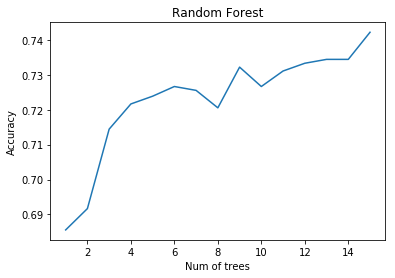

In [14]:
num_points = [1+i for i in range(15)]
acc_list = []

for tree_num in num_points:
    rf = RF(tree_num,0.4)
    acc_list.append(validate(rf,300))
    
plt.plot(num_points,acc_list)
plt.title("Random Forest")
plt.xlabel("Num of trees")
plt.ylabel("Accuracy")